# TITLE

"Speech Command Recognition: 49k Audio Files, 6GB GPU Training"

Notebook Flow: 
- Explore & Explanate the data that i got in my hands. (using only train.tsv file due computional power)
- Preprocess raw files, such as its columns, rows, etc. (mp3 audio files and words)
- Data processing with a Mel Spectrogram based Custom Dataloader.
- Split data into Train & Test workflow.
- Train Speech Command Models and its Structures Comparison.
- Analyse & Plot between Models differences.
- Full Conclusion.

# CNST

In [2]:
DATA_DIR = r'C:\Users\julio\Desktop\dev\artificial-intelligence\projects\speech2text\data\a_raw_data\cv-corpus-7.0-singleword\en'

SAVE_DIR_1000 = r'C:\Users\julio\Desktop\dev\artificial-intelligence\projects\speech2text\data\1000words'

SAVE_DIR_5000 = r'C:\Users\julio\Desktop\dev\artificial-intelligence\projects\speech2text\data\5000words'

MODEL_1_DIR = r'C:\Users\julio\Desktop\dev\artificial-intelligence\projects\speech2text\data\models\model1'

In [3]:
import os

TARGET_DIR = SAVE_DIR_5000

os.makedirs(TARGET_DIR, exist_ok=True)

In [4]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

# FNS

## import tsv

In [5]:
import pandas as pd

def import_tsv(file_name_ext: str, directory: str = DATA_DIR):

    file_path = os.path.join(directory, file_name_ext)
    df = pd.read_csv(file_path, sep='\t')

    print(f'import data shape: {df.shape}')
    return df

## save dataframe

In [6]:
# dataframes versions control
def save_dataframe(file_name_ext: str, df: pd.DataFrame, directory: str = TARGET_DIR):

    # file format define and checking
    fex_splitted = file_name_ext.split('.')
    file_name = fex_splitted[0]
    file_extension = fex_splitted[1]
    assert file_extension in ['parquet', 'csv', 'xlsx'], 'FILE FORMAT NOT ACCEPTING!!!'

    # ensure directory and file path existence
    path = os.path.join(directory, file_name)
    os.makedirs(directory, exist_ok=True)
    os.makedirs(path, exist_ok=True)

    # filter out target filename
    files_version = [file.split('_')[-1] for file in os.listdir(path) if file.split('_')[0] == file_name]

    # find the latest file version
    file_version = 'v1'
    if files_version:
        version_str = max(files_version).split('.')[0]
        file_version = ''.join([str(int(c)+1) if idx == 1 else c for idx, c in enumerate(list(version_str))])

    # define file path
    file_name_ext_2 = file_name + '_' + file_version + '.' + file_extension
    file_path = os.path.join(path, file_name_ext_2)

    # save file
    if file_extension == 'parquet':
        df.to_parquet(file_path, index=False)
    elif file_extension == 'csv':
        df.to_csv(file_path, index=False)
    elif file_extension == 'xlsx':
        df.to_excel(file_path, index=False)

    print(f'dataframe saved at "{file_path}" in {file_extension} format')

In [7]:
# save_dataframe(SAVE_DIR_5000, 'test.csv', pd.DataFrame({
#     'test': [1]
# }))

# PREPROCESSING

## import

due to the computational limitation (6gb of gpu), selecting only english data

In [8]:
import_df = import_tsv('train.tsv')

import_df.head()

import data shape: (16285, 10)


,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,1476c13940c901d1a5a10630c6d84205d0780be5beec08...,common_voice_en_22107292.mp3,Firefox,2,0,twenties,male,indian,en,Benchmark
1,1476c13940c901d1a5a10630c6d84205d0780be5beec08...,common_voice_en_22107294.mp3,eight,2,0,twenties,male,indian,en,Benchmark
2,1476c13940c901d1a5a10630c6d84205d0780be5beec08...,common_voice_en_22107295.mp3,Hey,3,0,twenties,male,indian,en,Benchmark
3,1476c13940c901d1a5a10630c6d84205d0780be5beec08...,common_voice_en_22107296.mp3,yes,2,0,twenties,male,indian,en,Benchmark
4,1476c13940c901d1a5a10630c6d84205d0780be5beec08...,common_voice_en_22107308.mp3,five,2,1,twenties,male,indian,en,Benchmark


## column

since i am only considering english dataset, so by exploring in the dataframe above i have noticed that only the path column (where i am importing audios files path) and sentence column (label data) is needed, so i am going to filter out others unnecessary columns

In [9]:
col_df = import_df[['path', 'sentence']]

col_df.head()

,path,sentence
0,common_voice_en_22107292.mp3,Firefox
1,common_voice_en_22107294.mp3,eight
2,common_voice_en_22107295.mp3,Hey
3,common_voice_en_22107296.mp3,yes
4,common_voice_en_22107308.mp3,five


in this second moment i am preprocessing all columns into format that will help to the data processing flow and model label benchmark

In [10]:
col_df_2 = col_df.copy()

col_df_2['path'] = col_df_2['path'].apply(lambda x: os.path.join(DATA_DIR, 'clips', x))
col_df_2['sentence'] = col_df_2['sentence'].apply(lambda x: str(x).lower().strip())

col_df_2

,path,sentence
0,C:\Users\julio\Desktop\dev\artificial-intellig...,firefox
1,C:\Users\julio\Desktop\dev\artificial-intellig...,eight
2,C:\Users\julio\Desktop\dev\artificial-intellig...,hey
3,C:\Users\julio\Desktop\dev\artificial-intellig...,yes
4,C:\Users\julio\Desktop\dev\artificial-intellig...,five
...,...,...
16280,C:\Users\julio\Desktop\dev\artificial-intellig...,four
16281,C:\Users\julio\Desktop\dev\artificial-intellig...,no
16282,C:\Users\julio\Desktop\dev\artificial-intellig...,one
16283,C:\Users\julio\Desktop\dev\artificial-intellig...,yes


In [11]:
# save_dataframe('col_df_2.parquet', col_df_2)

## analyse

lets convert and explore the audios files first!

### exploration

In [12]:
analyse_df = col_df_2.copy()

analyse_df

,path,sentence
0,C:\Users\julio\Desktop\dev\artificial-intellig...,firefox
1,C:\Users\julio\Desktop\dev\artificial-intellig...,eight
2,C:\Users\julio\Desktop\dev\artificial-intellig...,hey
3,C:\Users\julio\Desktop\dev\artificial-intellig...,yes
4,C:\Users\julio\Desktop\dev\artificial-intellig...,five
...,...,...
16280,C:\Users\julio\Desktop\dev\artificial-intellig...,four
16281,C:\Users\julio\Desktop\dev\artificial-intellig...,no
16282,C:\Users\julio\Desktop\dev\artificial-intellig...,one
16283,C:\Users\julio\Desktop\dev\artificial-intellig...,yes


In [13]:
analyse_df['path']

0        C:\Users\julio\Desktop\dev\artificial-intellig...
1        C:\Users\julio\Desktop\dev\artificial-intellig...
2        C:\Users\julio\Desktop\dev\artificial-intellig...
3        C:\Users\julio\Desktop\dev\artificial-intellig...
4        C:\Users\julio\Desktop\dev\artificial-intellig...
                               ...                        
16280    C:\Users\julio\Desktop\dev\artificial-intellig...
16281    C:\Users\julio\Desktop\dev\artificial-intellig...
16282    C:\Users\julio\Desktop\dev\artificial-intellig...
16283    C:\Users\julio\Desktop\dev\artificial-intellig...
16284    C:\Users\julio\Desktop\dev\artificial-intellig...
Name: path, Length: 16285, dtype: object

In [14]:
analyse_df['sentence'].unique()

array(['firefox', 'eight', 'hey', 'yes', 'five', 'three', 'two', 'seven',
       'no', 'six', 'nine', 'one', 'zero', 'four'], dtype=object)

In [15]:
analyse_first_row_df = analyse_df.iloc[0, :]

analyse_first_row_df

path        C:\Users\julio\Desktop\dev\artificial-intellig...
sentence                                              firefox
Name: 0, dtype: object

In [16]:
analyse_first_row_df['path']

'C:\\Users\\julio\\Desktop\\dev\\artificial-intelligence\\projects\\speech2text\\data\\a_raw_data\\cv-corpus-7.0-singleword\\en\\clips\\common_voice_en_22107292.mp3'

In [17]:
import torchaudio

analyse_first_audio_sample = analyse_first_row_df['path']
analyse_first_audio_sentence = analyse_first_row_df['sentence']

analyse_wav_test, analyse_sr_test = torchaudio.load(analyse_first_audio_sample)

analyse_wav_test.shape, analyse_sr_test, analyse_first_audio_sentence

(torch.Size([1, 192384]), 48000, 'firefox')

In [18]:
import random
import torchaudio

analyse_random_row_df = analyse_df.iloc[int(random.randint(0, 16285))]

analyse_random_audio_sample = analyse_random_row_df['path']
analyse_random_audio_sentence = analyse_random_row_df['sentence']

analyse_wav_test_rand, analyse_sr_test_rand = torchaudio.load(analyse_random_audio_sample)

analyse_wav_test_rand.shape, analyse_sr_test_rand, analyse_random_audio_sentence

(torch.Size([1, 89856]), 48000, 'two')

In [19]:
from torchaudio import transforms

analyse_spec_transform_test = transforms.Spectrogram(n_fft=1024, hop_length=512, power=2.0)
analyse_wav_test_spec = analyse_spec_transform_test(analyse_wav_test)

analyse_wav_test_spec, analyse_wav_test_spec.shape

(tensor([[[1.0717e-13, 6.4591e-11, 1.7559e-04,  ..., 1.3611e-02,
           1.6755e-02, 1.2142e-07],
          [5.4996e-15, 5.1500e-11, 1.3265e-04,  ..., 1.2134e-01,
           2.0222e-01, 1.2704e-07],
          [6.3500e-14, 2.1603e-11, 9.0787e-05,  ..., 2.2318e+00,
           6.2923e-01, 1.5132e-07],
          ...,
          [4.6549e-25, 1.1621e-18, 7.7605e-15,  ..., 1.3524e-11,
           8.1863e-12, 1.9229e-14],
          [1.1665e-24, 8.6745e-19, 1.2882e-15,  ..., 3.3523e-12,
           4.5486e-12, 7.0432e-15],
          [3.6262e-24, 7.6392e-19, 5.4819e-15,  ..., 9.0949e-13,
           2.4714e-12, 7.9054e-17]]]),
 torch.Size([1, 513, 376]))

In [20]:
analyse_spectro_test = analyse_wav_test_spec.log2()[0].numpy()

analyse_spectro_test, analyse_spectro_test.shape

(array([[-43.085217 , -33.849873 , -12.475532 , ...,  -6.1991053,
          -5.899261 , -22.97351  ],
        [-47.369602 , -34.176632 , -12.880095 , ...,  -3.0429316,
          -2.3059804, -22.908194 ],
        [-43.840237 , -35.42998  , -13.427149 , ...,   1.1581799,
          -0.6683301, -22.655937 ],
        ...,
        [-80.82945  , -59.57794  , -46.872772 , ..., -36.10573  ,
         -36.829918 , -45.563694 ],
        [-79.50413  , -59.999855 , -49.463596 , ..., -38.117973 ,
         -37.67772  , -47.012688 ],
        [-77.86782  , -60.183216 , -47.374233 , ..., -40.       ,
         -38.5578   , -53.489944 ]], dtype=float32),
 (513, 376))

### explanation

focusing on single sample analyse, and also compare technique to applied for future processing

#### conventional spectrogram

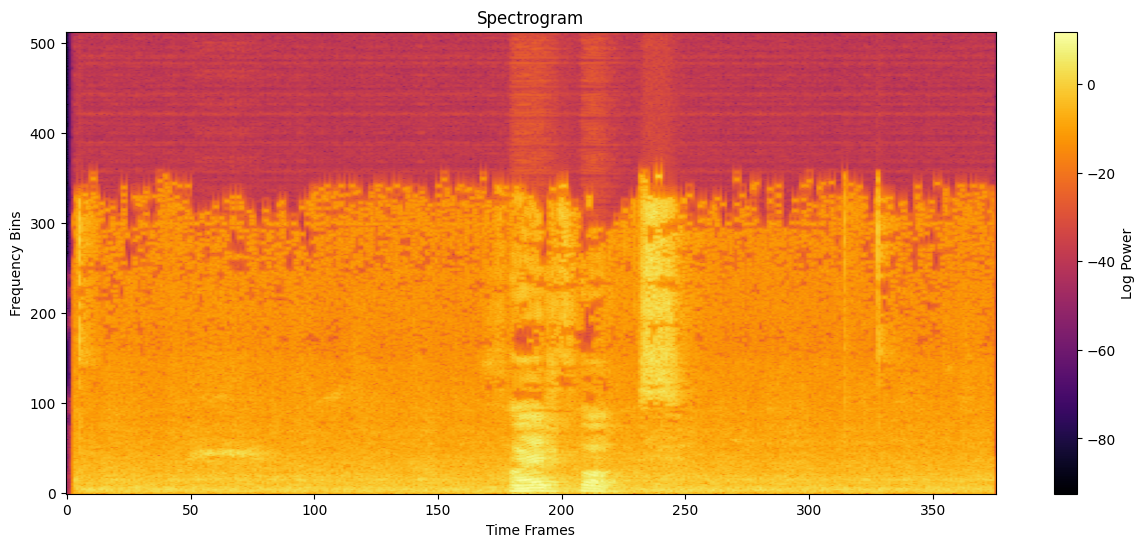

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.imshow(analyse_spectro_test, cmap='inferno', aspect='auto', origin='lower')
plt.colorbar(label="Log Power")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.title("Spectrogram")
plt.show()

In [22]:
analyse_mel_transform_test = transforms.MelSpectrogram(n_fft=1024, hop_length=512, power=2.0, sample_rate=analyse_sr_test)
analyse_wav_test_mel = analyse_mel_transform_test(analyse_wav_test)

analyse_wav_test_mel, analyse_wav_test_mel.shape

C:\Users\julio\AppData\Roaming\Python\Python312\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.6115e-15, 3.3820e-11, 8.7110e-05,  ..., 7.9680e-02,
           1.3280e-01, 8.3427e-08],
          [1.8880e-15, 1.7680e-11, 4.5540e-05,  ..., 4.1655e-02,
           6.9425e-02, 4.3614e-08],
          ...,
          [2.2109e-23, 1.4078e-18, 5.1486e-13,  ..., 4.5558e-11,
           5.9092e-11, 2.0205e-13],
          [1.8903e-23, 1.8769e-18, 2.9668e-13,  ..., 6.9983e-11,
           5.8673e-11, 5.1226e-13],
          [7.1346e-23, 8.3640e-18, 1.7710e-12,  ..., 5.6870e-11,
           6.2060e-11, 4.0369e-13]]]),
 torch.Size([1, 128, 376]))

In [23]:
analyse_mel_test = analyse_wav_test_mel.log2()[0].detach().numpy()

analyse_mel_test, analyse_mel_test.shape

(array([[       -inf,        -inf,        -inf, ...,        -inf,
                -inf,        -inf],
        [-47.976315 , -34.783344 , -13.486806 , ...,  -3.6496434,
          -2.9126925, -23.514906 ],
        [-48.912025 , -35.719055 , -14.422518 , ...,  -4.585355 ,
          -3.848404 , -24.450617 ],
        ...,
        [-75.25968  , -59.30123  , -40.82089  , ..., -34.353504 ,
         -33.978237 , -42.17037  ],
        [-75.48576  , -58.88635  , -41.616154 , ..., -33.734203 ,
         -33.988506 , -40.828197 ],
        [-73.56951  , -56.73051  , -39.03861  , ..., -34.033543 ,
         -33.907555 , -41.1718   ]], dtype=float32),
 (128, 376))

#### mel spectrogram

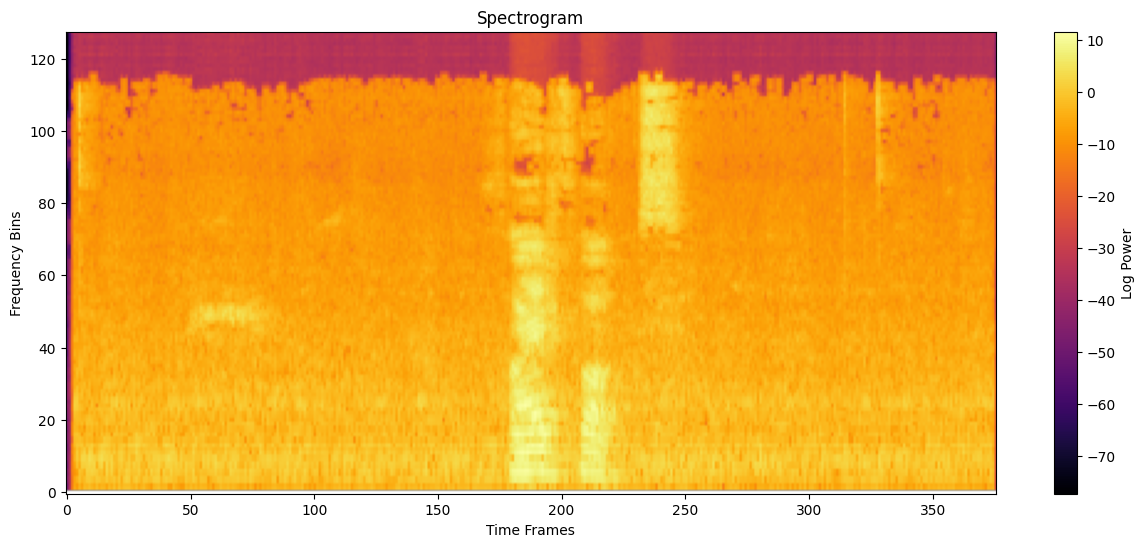

In [24]:
plt.figure(figsize=(15, 6))
plt.imshow(analyse_mel_test, cmap='inferno', aspect='auto', origin='lower')
plt.colorbar(label="Log Power")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.title("Spectrogram")
plt.show()

### display audio

In [25]:
from IPython.display import Audio

Audio(analyse_first_audio_sample)

### directory checking

In [26]:
analyse_df['path'][:10]

0    C:\Users\julio\Desktop\dev\artificial-intellig...
1    C:\Users\julio\Desktop\dev\artificial-intellig...
2    C:\Users\julio\Desktop\dev\artificial-intellig...
3    C:\Users\julio\Desktop\dev\artificial-intellig...
4    C:\Users\julio\Desktop\dev\artificial-intellig...
5    C:\Users\julio\Desktop\dev\artificial-intellig...
6    C:\Users\julio\Desktop\dev\artificial-intellig...
7    C:\Users\julio\Desktop\dev\artificial-intellig...
8    C:\Users\julio\Desktop\dev\artificial-intellig...
9    C:\Users\julio\Desktop\dev\artificial-intellig...
Name: path, dtype: object

## rows

we are going to cut off some of the data for our model training, for models efficienty comparison

In [27]:
row_df = analyse_df.loc[:4999, :]

row_df

,path,sentence
0,C:\Users\julio\Desktop\dev\artificial-intellig...,firefox
1,C:\Users\julio\Desktop\dev\artificial-intellig...,eight
2,C:\Users\julio\Desktop\dev\artificial-intellig...,hey
3,C:\Users\julio\Desktop\dev\artificial-intellig...,yes
4,C:\Users\julio\Desktop\dev\artificial-intellig...,five
...,...,...
4995,C:\Users\julio\Desktop\dev\artificial-intellig...,seven
4996,C:\Users\julio\Desktop\dev\artificial-intellig...,no
4997,C:\Users\julio\Desktop\dev\artificial-intellig...,hey
4998,C:\Users\julio\Desktop\dev\artificial-intellig...,six


In [28]:
# save_dataframe('row_df.parquet', row_df)

## mp3 to array

targeting audio array, in order to make it adaptive for model input

### define

In [29]:
from tqdm import tqdm
import numpy as np

def convert_mp3_audio(df: pd.DataFrame, target_sr: int = 16_000) -> pd.DataFrame:

    samples = []
    samples_length = []
    s_rates = []

    for f_path in tqdm(df['path'], desc='Processing Audio Files'):

        wv, sr = torchaudio.load(f_path)

        if sr != target_sr:
            transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
            wv = transform(wv)

        wv_np = np.array(wv.squeeze(0))

        samples.append(wv_np)
        samples_length.append(wv.shape[1])
        s_rates.append(target_sr)

    
    print(f'audios mp3 converted into audios arrays')
    return samples, samples_length, s_rates

### convert

In [30]:
# samples, samples_length, s_rates = convert_mp3_audio(row_df)

# samples, samples_length, s_rates

In [31]:
# mp3toArray_df = pd.DataFrame({
#         'sample': samples,
#         'sample_length': samples_length,
#         's_rate': s_rates,
#         'sentence': cut_df['sentence']
#     })

# mp3toArray_df

### export

In [32]:
# save_dataframe('mp3toArray_df.parquet', mp3toArray_df)

### view

due to the time lagging of processing files, i am going to comment processed files and read it here for demostration propose

In [33]:
mp3toArray_df = pd.read_parquet(r'C:\Users\julio\Desktop\dev\artificial-intelligence\projects\speech2text\data\5000words\mp3toArray_df\mp3toArray_df_v1.parquet')

mp3toArray_df

,sample,sample_length,s_rate,sentence
0,"[-4.972494e-15, 6.0329334e-16, -3.0127078e-14,...",64128,16000,firefox
1,"[-6.826116e-14, -1.389217e-13, -3.2283289e-15,...",56832,16000,eight
2,"[1.10146335e-14, -1.0613964e-14, -4.666261e-14...",47232,16000,hey
3,"[2.2804805e-14, 7.183714e-14, 1.2546503e-13, 1...",59520,16000,yes
4,"[9.605254e-15, 3.139316e-14, 3.8130367e-14, 5....",39168,16000,five
...,...,...,...,...
4995,"[3.3227457e-15, 9.466913e-15, 7.780626e-15, -8...",54144,16000,seven
4996,"[-1.4753183e-14, -2.84789e-14, 1.7413773e-14, ...",44928,16000,no
4997,"[-6.2152093e-15, 7.959361e-15, -1.4356778e-14,...",49536,16000,hey
4998,"[-1.0072409e-14, -5.4420664e-15, 9.825669e-15,...",44544,16000,six


# PROCESSING

now its time to process the clean and organized data into suitable model format data

## word spiece

extracting sentences and tokenize them into json vocabulary for later usage

### extract

In [34]:
# get unique words and save
unique_words = mp3toArray_df['sentence'].unique()

text_path = os.path.join(TARGET_DIR, 'words.txt')

with open(text_path, 'w', encoding='utf-8') as f:
    for word in unique_words:
        f.write(word + '\n')

print(f'vocab saved at {text_path}')

vocab saved at C:\Users\julio\Desktop\dev\artificial-intelligence\projects\speech2text\data\5000words\words.txt


### tokenizer

In [35]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace

def train_tokenizer(unique_words: list, path: str = TARGET_DIR):

    # ensure path existence
    tokens_path = os.path.join(path, 'tokenizer_checkpoint.json')
    
    # instantiate tokenizer
    tokenizer = Tokenizer(WordPiece(unk_token='[UNK]'))
    tokenizer.pre_tokenizer = Whitespace()

    # molde the tokenizer and save
    special_tokens = ['[UNK]', '[CLS]', '[SEP]', '[MASK]']
    tokenizer.train([text_path], WordPieceTrainer(vocab_size=len(unique_words), min_frequency=1, special_tokens=special_tokens))
    tokenizer.save(tokens_path)

    print(f'tokenizer checkpoint saved at {tokens_path}')
    
    return tokenizer

In [36]:
tokenizer = train_tokenizer(unique_words)

tokenizer

tokenizer checkpoint saved at C:\Users\julio\Desktop\dev\artificial-intelligence\projects\speech2text\data\5000words\tokenizer_checkpoint.json


Tokenizer(version="1.0", truncation=None, padding=None, added_tokens=[{"id":0, "content":"[UNK]", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":1, "content":"[CLS]", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":2, "content":"[SEP]", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":3, "content":"[MASK]", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}], normalizer=None, pre_tokenizer=Whitespace(), post_processor=None, decoder=None, model=WordPiece(unk_token="[UNK]", continuing_subword_prefix="##", max_input_chars_per_word=100, vocab={"[UNK]":0, "[CLS]":1, "[SEP]":2, "[MASK]":3, "e":4, "f":5, "g":6, "h":7, "i":8, "n":9, "o":10, "r":11, "s":12, "t":13, "u":14, "v":15, "w":16, "x":17, "y":18, "z":19, "##e":20, "##v":21, "##n":22, "##o":23, "##u":24, "##r":25, "##i":26, "##f":27, "##x":28, "##w":29, "##y"

In [37]:
vocab_size= tokenizer.get_vocab()

len(vocab_size)

35

### detokenizer

In [38]:
def detokenize(token_ids):
    word = []
    for item in token_ids.split(' '):
        if item.startswith('##'):
            item = item[2:]
        word.append(item)
    return ''.join(word)

In [39]:
x = '##eu eu'

x[2:] if x.startswith('##') else 0


'eu eu'

In [40]:
detokenize(x)

'eueu'

### process

In [41]:
tokens = list(mp3toArray_df['sentence'].apply(lambda x: tokenizer.encode(x).ids))

tokens, len(tokens)

([[5, 26, 25, 20, 27, 23, 28],
  [4, 26, 33, 31, 34],
  [7, 20, 30],
  [18, 20, 32],
  [5, 26, 21, 20],
  [13, 31, 25, 20, 20],
  [13, 29, 23],
  [12, 20, 21, 20, 22],
  [9, 23],
  [12, 26, 28],
  [9, 26, 22, 20],
  [10, 22, 20],
  [12, 20, 21, 20, 22],
  [7, 20, 30],
  [5, 26, 25, 20, 27, 23, 28],
  [4, 26, 33, 31, 34],
  [9, 23],
  [18, 20, 32],
  [12, 26, 28],
  [5, 26, 21, 20],
  [19, 20, 25, 23],
  [10, 22, 20],
  [9, 26, 22, 20],
  [5, 23, 24, 25],
  [19, 20, 25, 23],
  [5, 26, 21, 20],
  [10, 22, 20],
  [7, 20, 30],
  [12, 20, 21, 20, 22],
  [12, 26, 28],
  [9, 26, 22, 20],
  [4, 26, 33, 31, 34],
  [13, 29, 23],
  [5, 26, 25, 20, 27, 23, 28],
  [9, 23],
  [18, 20, 32],
  [18, 20, 32],
  [7, 20, 30],
  [10, 22, 20],
  [12, 26, 28],
  [5, 26, 21, 20],
  [5, 26, 25, 20, 27, 23, 28],
  [19, 20, 25, 23],
  [13, 31, 25, 20, 20],
  [12, 20, 21, 20, 22],
  [4, 26, 33, 31, 34],
  [5, 23, 24, 25],
  [9, 23],
  [9, 26, 22, 20],
  [5, 26, 25, 20, 27, 23, 28],
  [5, 23, 24, 25],
  [12, 20, 2

### padding

In [42]:
from torch.nn.utils.rnn import pad_sequence

tokens_tensor = [torch.tensor(tok, dtype=torch.long) for tok in tokens]
pad_tokens = pad_sequence(tokens_tensor, batch_first=True, padding_value=0)

pad_tokens, len(pad_tokens), len(pad_tokens[0])

(tensor([[ 5, 26, 25,  ..., 27, 23, 28],
         [ 4, 26, 33,  ..., 34,  0,  0],
         [ 7, 20, 30,  ...,  0,  0,  0],
         ...,
         [ 7, 20, 30,  ...,  0,  0,  0],
         [12, 26, 28,  ...,  0,  0,  0],
         [18, 20, 32,  ...,  0,  0,  0]]),
 5000,
 7)

In [43]:
# token_df = pd.DataFrame({
#     'token_ids': tokens,
#     'words': mp3toArray_df['sentence']
# })

# save_dataframe('token_df.xlsx', token_df)

## mel spectro

after processing sentence tokens, lets convert audio array into mel spectro tensors data type, for future a better cnn feature extraction flow

### extract

In [44]:
audio_samples = mp3toArray_df['sample']

audio_samples

0       [-4.972494e-15, 6.0329334e-16, -3.0127078e-14,...
1       [-6.826116e-14, -1.389217e-13, -3.2283289e-15,...
2       [1.10146335e-14, -1.0613964e-14, -4.666261e-14...
3       [2.2804805e-14, 7.183714e-14, 1.2546503e-13, 1...
4       [9.605254e-15, 3.139316e-14, 3.8130367e-14, 5....
                              ...                        
4995    [3.3227457e-15, 9.466913e-15, 7.780626e-15, -8...
4996    [-1.4753183e-14, -2.84789e-14, 1.7413773e-14, ...
4997    [-6.2152093e-15, 7.959361e-15, -1.4356778e-14,...
4998    [-1.0072409e-14, -5.4420664e-15, 9.825669e-15,...
4999    [-3.7155156e-17, -6.055522e-17, -2.343608e-16,...
Name: sample, Length: 5000, dtype: object

### mel

In [45]:
import torch

def convert_into_mel(samples):
    transforms = torchaudio.transforms.MelSpectrogram(sample_rate=16_000, n_fft=1024, hop_length=512)
    mel_samples = [transforms(torch.tensor(sample, dtype=torch.float32)) for sample in samples]
    print(f'mel sample shape: {mel_samples[-1].shape}')
    return mel_samples

### process

In [46]:
mel_samples = list(convert_into_mel(audio_samples))

mel_samples

mel sample shape: torch.Size([128, 82])


[tensor([[8.7205e-07, 9.3792e-04, 1.9386e-04,  ..., 1.6260e-04, 1.6180e-04,
          9.2883e-04],
         [6.7174e-07, 4.9399e-03, 2.1495e-03,  ..., 6.4398e-03, 5.9910e-03,
          2.5917e-03],
         [4.0186e-07, 7.6106e-03, 3.4565e-02,  ..., 2.8922e-02, 9.6256e-03,
          4.6575e-03],
         ...,
         [6.2210e-08, 3.5694e-03, 8.3729e-02,  ..., 4.3348e-04, 2.1222e-04,
          1.9654e-05],
         [2.8863e-08, 4.6437e-03, 4.4938e-02,  ..., 1.0253e-04, 5.8718e-05,
          9.4464e-06],
         [2.6235e-08, 1.3799e-02, 1.5185e-01,  ..., 1.5539e-04, 3.2347e-05,
          3.7699e-06]]),
 tensor([[4.4909e-06, 3.4311e-04, 6.2768e-03,  ..., 2.1369e-02, 4.4253e-03,
          1.2439e-02],
         [4.2308e-06, 3.1785e-03, 1.5914e-02,  ..., 1.8949e-02, 7.4139e-03,
          5.1173e-03],
         [3.6484e-06, 1.1113e-02, 4.8010e-02,  ..., 1.5070e-02, 2.4192e-02,
          8.4349e-03],
         ...,
         [4.3938e-09, 2.4247e-04, 8.3741e-03,  ..., 1.7085e-04, 1.6757e-04,
   

## split

extract formatted and essential data for splitting data into train and test, before loader for data reproducibility and consistency

In [47]:
len(mel_samples), len(tokens)

(5000, 5000)

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mel_samples, tokens_tensor, test_size=0.2, random_state=42, shuffle=True)

print(f'training size (x, y) -> {len(X_train), len(y_train)}')
print(f'and test size (x, y) -> {len(X_test), len(y_test)}')

X_train

training size (x, y) -> (4000, 4000)
and test size (x, y) -> (1000, 1000)


[tensor([[7.8639e-13, 3.3506e-07, 4.3144e-06,  ..., 1.4103e-09, 3.6279e-09,
          2.8668e-10],
         [7.1206e-12, 6.8689e-08, 3.0565e-06,  ..., 3.5133e-09, 5.7665e-10,
          1.4295e-10],
         [3.9187e-12, 1.5938e-07, 2.1417e-06,  ..., 1.7673e-09, 1.7961e-10,
          4.3375e-11],
         ...,
         [2.7657e-11, 1.7235e-06, 7.6329e-04,  ..., 1.2887e-08, 6.1282e-10,
          6.2051e-11],
         [4.8154e-12, 4.8279e-07, 4.4542e-04,  ..., 8.9282e-09, 5.5312e-10,
          5.6827e-11],
         [1.2135e-11, 2.9138e-07, 5.4300e-04,  ..., 3.1947e-09, 3.5750e-10,
          3.8645e-11]]),
 tensor([[3.9365e-07, 1.1900e-02, 4.7598e-01,  ..., 5.0509e-05, 3.6719e-04,
          1.1328e-04],
         [1.7703e-07, 1.1032e-02, 6.0566e-01,  ..., 2.7356e-04, 2.9151e-03,
          8.9788e-05],
         [4.7666e-08, 2.3394e-01, 4.5585e-01,  ..., 4.8221e-03, 6.2094e-03,
          2.7701e-04],
         ...,
         [1.4509e-07, 1.3599e-03, 4.2387e-04,  ..., 2.2562e-04, 2.0286e-04,
   

In [49]:
y_train

tensor([[ 4, 26, 33,  ..., 34,  0,  0],
        [12, 20, 21,  ..., 22,  0,  0],
        [ 9, 26, 22,  ...,  0,  0,  0],
        ...,
        [ 5, 26, 25,  ..., 27, 23, 28],
        [ 9, 23,  0,  ...,  0,  0,  0],
        [ 5, 23, 24,  ...,  0,  0,  0]])

## loader

creating loader for training set, before that we must analyse the mel data that we are getting to load into batches

In [50]:
# getting data max length for loading into batches with padding
audio_max_length = max([mel.shape[1] for mel in mel_samples])

audio_max_length

361

In [76]:
import typing as tp

# mel_tensors: (C, T)
# knowing that audios array have 1000 units, so we can batch perfectly into test_batches of 4, also because of 
# my notebook only has 6gb of gpu ram so i can only run this little test_batches per time, 
# setting audio max len to 298 to add natural silence into missing parts, plus we got 128 of mel frequency bins by cepstral by default
def mel_loader_2(
        mel_tensors: tp.List[torch.tensor], token_ids: list, 
        batch_size: int = 4, mel_freq_bins: int = 128, mel_time_step: int = 298
        ):
    """
        Custom Data Loader for Mel Spectrogram
    """
    assert all([mel.shape[0] == 128 for mel in mel_tensors]), 'MEL FREQUENCY NOT MATCHING!!!' # ensure that we got the right data size

    # calculating total batches number
    all_len = len(mel_tensors)
    batches_len = all_len//batch_size

    # explicitly padding mel tensors (just adding missing parts then concat it)
    mels_padded = torch.stack([
        torch.concat([mel, torch.zeros(mel_freq_bins, mel_time_step-mel.shape[1])], dim=1)
        if mel.shape[1] < mel_time_step else mel[:, :mel_time_step]
        for mel in mel_tensors
    ])

    # returning padded mels and token_ids but formatted into desired sizes
    batches_audio = mels_padded.view(batches_len, batch_size, mel_freq_bins, mel_time_step)
    batches_token_ids = [token_ids[idx*batch_size : (idx+1)*batch_size] for idx in range(batches_len)]

    # ctc loss label associated values
    sent_b_len = len(batches_token_ids)
    # flattened_batches_token_ids = torch.cat([torch.as_tensor(seq, dtype=torch.long) for seq in batches_token_ids])
    flattened_batches_token_ids = [
        torch.cat([torch.as_tensor(seq, dtype=torch.long) for seq in batch]) for batch in batches_token_ids
        ]
    
    # ctc loss parameters
    input_length = torch.tensor([[b2.shape[-1] for b2 in b] for b in batches_audio])
    label_length = torch.tensor([[len(b2) for b2 in b] for b in batches_token_ids])

    # print(f'batched audios shape: {batches_audio.shape}')
    # print(f'batched token_ids shape: {sent_b_len, len(batches_token_ids[random.randint(0, sent_b_len)])}')
    # print(f'ctc loss, \ninput: {input_length} \nlabel: {label_length}')

    return list(zip(batches_audio, flattened_batches_token_ids, input_length, label_length))

### simulation

In [68]:
simulation_dataset = mel_loader_2(X_train, y_train)

In [65]:
simulation_dataset[56][1]

tensor([ 7, 20, 30,  0,  0,  0,  0,  9, 26, 22, 20,  0,  0,  0, 12, 26, 28,  0,
         0,  0,  0,  9, 23,  0,  0,  0,  0,  0])

In [69]:
simulation_dataset[56][1]

tensor([ 7, 20, 30,  9, 26, 22, 20, 12, 26, 28,  9, 23])

In [74]:
simulation_dataset[56][3]

tensor([3, 4, 3, 2])

In [75]:
simulation_dataset[56][2]

tensor([298, 298, 298, 298])

# MODELS

## model 1

In [77]:
import torch.nn as nn
import math

class ResidualBlock(nn.Module):
    """dilated residual block"""
    def __init__(self, in_channels, out_channels, kernel_size=7, dilation=1):
        super().__init__()
        self.conv_filter = nn.Conv1d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            padding=((kernel_size-1) * dilation // 2),
            dilation=dilation,
        )
        self.conv_gate = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=((kernel_size-1) * dilation // 2),
            dilation=dilation
        )
        self.conv_out = nn.Conv1d(
            out_channels, 
            out_channels, 
            kernel_size=1
        )
        self.bn_filter = nn.BatchNorm1d(out_channels)
        self.bn_gate = nn.BatchNorm1d(out_channels)
        self.bn_out = nn.BatchNorm1d(out_channels)
    def forward(self, x):
        filter_out = torch.tanh(self.bn_filter(self.conv_filter(x)))
        gate_out = torch.sigmoid(self.bn_gate(self.conv_gate(x)))
        out = filter_out * gate_out # element wise multiplication
        out = torch.tanh(self.bn_out(self.conv_out(out)))
        return x + out, out # residual and skip connection

class FeatureEncoder(nn.Module):
    """cnn to extract mfcc features and incorporated residual blocks"""
    def __init__(self, in_channels=128, out_channels=512, num_blocks=3):
        super().__init__()
        self.front_conv = nn.Sequential(
            nn.Conv1d(in_channels, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.Tanh(),
        )
        self.num_blocks = num_blocks
        self.res_blocks = nn.ModuleList()
        for i in range(num_blocks):
            for ratio in [1, 2, 4, 8, 16]:
                self.res_blocks.append(ResidualBlock(128, 128, kernel_size=7, dilation=ratio))
        self.final_conv = nn.Sequential(
            nn.Conv1d(128, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.front_conv(x)
        skip_connection = 0
        for res_block in self.res_blocks:
            x, skip = res_block(x)
            skip_connection += skip
        return self.final_conv(skip_connection)

class PositionalEncoder(nn.Module):
    """sin and cos positional embedding"""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, d_model, 2)) * (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:x.size(0), :, :]
        return self.dropout(x)

class TransformerEncoder(nn.Module):
    """transformer encoder"""
    def __init__(self, input_dim=512, num_head=8, ff_dim=2048, n_layers=12, dropout=0.1):
        super().__init__()
        # self.pos_encoder = PositionalEncoder(d_model=input_dim, dropout=dropout)
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_head,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            activation=nn.GELU(),
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=n_layers)
    def forward(self, x, src_key_padding_mask=None):
        x = x.permute(0, 2, 1)
        # x = self.pos_encoder(x)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        return x

class SpeechTextNeural1(nn.Module):
    """neural"""
    def __init__(
        self, 
        vocab_size, 
        input_dim=512, 
        ff_dim=2048, 
        transformer_layers=12, 
        transformer_heads=8):
        super().__init__()
        self.encoder = FeatureEncoder()
        self.transformer = TransformerEncoder(
            input_dim, 
            transformer_heads, 
            ff_dim, 
            transformer_layers
        )
        self.fc1 = nn.Linear(input_dim, vocab_size)
    def forward(self, x):
        # print(f'before encoder: {x.shape}')
        x = self.encoder(x)
        # print(f'after encoder: {x.shape}')
        # print(f'before transformer: {x.shape}')
        x = self.transformer(x)
        # print(f'after transformer: {x.shape}')
        # print(f'before full connector: {x.shape}')
        x = self.fc1(x).permute(1, 0, 2)
        # print(f'after full connector: {x.shape}')
        return x

### setup

In [78]:
import torch.optim as optim

model1 = SpeechTextNeural1(len(vocab_size)).to(device)

optimizer1 = optim.Adam(model1.parameters(), lr=1e-3)
criterion1 = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

In [72]:
from torchinfo import summary

summary(model1, input_size=(4, 128, 298), depth=10)

Layer (type:depth-idx)                                  Output Shape              Param #
SpeechTextNeural1                                       [298, 4, 35]              --
├─FeatureEncoder: 1-1                                   [4, 512, 298]             --
│    └─Sequential: 2-1                                  [4, 128, 298]             --
│    │    └─Conv1d: 3-1                                 [4, 128, 298]             16,512
│    │    └─BatchNorm1d: 3-2                            [4, 128, 298]             256
│    │    └─Tanh: 3-3                                   [4, 128, 298]             --
│    └─ModuleList: 2-2                                  --                        --
│    │    └─ResidualBlock: 3-4                          [4, 128, 298]             --
│    │    │    └─Conv1d: 4-1                            [4, 128, 298]             114,816
│    │    │    └─BatchNorm1d: 4-2                       [4, 128, 298]             256
│    │    │    └─Conv1d: 4-3                     

## benchmark

### load sample

In [73]:
test_loader = mel_loader_2(X_test, y_test)

test_loader

[(tensor([[[3.1003e-09, 1.2587e-05, 1.0105e-05,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [5.4144e-09, 8.8130e-06, 1.5227e-05,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [4.2895e-09, 1.3158e-05, 1.6607e-05,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [1.5646e-09, 7.6056e-07, 6.3967e-07,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [3.0284e-09, 8.6305e-07, 4.7417e-07,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [1.5275e-09, 8.3822e-07, 6.9103e-07,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]],
  
          [[9.9528e-08, 3.2784e-02, 1.9023e-01,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [9.4342e-08, 5.2808e-02, 4.8494e-02,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [8.4875e-08, 5.6821e-02, 3.2057e-02,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [6.6391e-09, 2.0140e-04, 3

### accuracy

In [58]:
from Levenshtein import distance
import torch.nn.functional as F
from torch.nn import CTCLoss

def model_initial_acc(model):

    sample, flatten_label, input_length, label_length = test_loader[(random.randint(0, len(test_loader)-1))]

    # model output
    model.eval()
    output = model(sample.to(device))

    # ctc acc
    log_probs = F.log_softmax(output, dim=2)
    criterion = CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    ctc_loss = criterion(log_probs, flatten_label, input_length, label_length)

    # levenshtein acc
    pred = output.argmax(dim=2).T
    print(pred, pred.shape)
    print(flatten_label.shape)
    tokens_decoded = [(tokenizer.decode(list(l_seq)), tokenizer.decode(list(p_seq))) for l_seq, p_seq in zip(flatten_label, pred)]
    print(tokens_decoded)
    sentences_pair = [(detokenize(l_seq), detokenize(p_seq)) for (l_seq, p_seq) in tokens_decoded]
    print(sentences_pair)
    levenshtein_acc = np.mean([round(1-distance((l), (p))/max(len(l), len(p)), 4) for (l, p) in sentences_pair])

    print('acc: ', levenshtein_acc)
    print('loss: ', ctc_loss.detach().cpu().numpy())

#### model 1

In [ ]:
# model_initial_acc(model1)

tensor([[15, 15, 15,  ..., 15, 15, 15],
        [ 9,  9,  9,  ..., 15, 15, 15],
        [ 9, 15, 15,  ..., 15, 15, 15],
        [15, 15, 15,  ..., 15, 15, 15]], device='cuda:0') torch.Size([4, 298])
torch.Size([28])


TypeError: iteration over a 0-d tensor

# TRAIN

## checkpoint

In [80]:
from datetime import datetime

def save_model(path_v, epoch, b_idx, model, optimizer, training_losses):
    
    # create dir if not exists
    os.makedirs(path_v, exist_ok=True)
    existing_files = [
        f for f in os.listdir(path_v) if f.endswith('.pth') and f.startswith('model')]
    versions = []
    
    # get the latest version
    for file in existing_files:
        filename = file.replace('.pth', '').split('_')
        if len(filename) > 1 and filename[-1].isdigit():
            versions.append(int(filename[-1]))
    new_version = max(versions)+1 if versions else 1

    # model checkpoint collection
    checkpoint = {
        'epoch': epoch,
        'batch_index': b_idx,
        'time': datetime.now(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_losses': training_losses,
    }
    
    # save checkpoint into new path
    new_path = os.path.join(path_v, f'model_30percent_{new_version}.pth')
    torch.save(checkpoint, new_path)
    
    print(f'MODEL SAVED AT {new_path}')

## epoch

In [79]:
import time
from datetime import datetime

def train(model, dataloader, epochs=10):
    
    # model training mode
    model.train()
    training_losses = []
    
    for epoch in range(epochs):

        es_time = time.perf_counter() # start epoch inf_time
        
        total_loss = 0.
        b_idx = 0

        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'EPOCH: {epoch}', leave=True)
        
        for idx, (mel_array, token_ids, input_length, label_length) in progress_bar:
            
            b_idx = idx # batch index
            bs_time = time.perf_counter() # start batch inf_time
            
            # inference & correction
            optimizer1.zero_grad()

            outputs = model(mel_array.to(device))

            log_probs = F.log_softmax(outputs, dim=2)
            log_probs = log_probs.clamp(min=1e-9).log()  # prevent log(0) issues

            # log_probs = outputs.log_softmax(2)

            # print(f"log_probs shape: {log_probs.shape}")
            # print(torch.isnan(log_probs).sum())  # should be 0

            # print(f"log_probs min: {log_probs.min().item()}, max: {log_probs.max().item()}")  # check log probability range
            # print(f"token_ids shape: {token_ids.shape}, input_length: {input_length}, label_length: {label_length}")
            loss = criterion1(
                log_probs, 
                token_ids.to(device), 
                (input_length).to(device), 
                (label_length).to(device)
            )
            # print(f"Computed loss: {loss.item()}")  # print loss before backpropagation
            loss.backward()
            optimizer1.step()

            # losses
            batch_loss = loss.item()
            total_loss += batch_loss
            training_losses.append(batch_loss)
            
            be_time = time.perf_counter() - bs_time # end batch inf_time
            
            if idx % 50 == 0:
                print(f'date time {datetime.now()} --------------------------')
                print(f'epoch: {epoch}, batch -> {idx}, loss: {batch_loss:.4f}, batch_time: {be_time:.4f}s')
                with open(os.path.join(MODEL_1_DIR, 'model1_train_history_v1.txt'), 'a', encoding='utf-8') as f:
                    f.write(f'\ndate time {datetime.now()} --------------------------\n')
                    f.write(f'epoch: {epoch}, batch -> {idx}, loss: {batch_loss:.4f}, batch_time: {be_time:.4f}s\n')
            elif idx % 2500 == 0:
                save_model(MODEL_1_DIR, epoch, b_idx, model, optimizer1, training_losses)
                
        ee_time = time.perf_counter() - es_time # end epoch inf_time

        print(f'EPOCH {epoch+1}, LOSS: {total_loss:.4f}, EPOCH_TIME: {ee_time}.')
        with open(os.path.join(MODEL_1_DIR, 'model1_train_history_v1.txt'), 'a', encoding='utf-8') as f:
            f.write(f'\n\nEPOCH {epoch+1}, LOSS: {total_loss:.4f}, EPOCH_TIME: {ee_time}.\n\n')
        
        save_model(MODEL_1_DIR, epoch, b_idx, model, optimizer1, training_losses)

### train

In [81]:
train(model1, mel_loader_2(X_train, y_train), 3)

EPOCH: 0:   0%|          | 2/1000 [00:00<06:12,  2.68it/s]

date time 2025-04-03 22:49:50.025689 --------------------------
epoch: 0, batch -> 0, loss: 1303.8291, batch_time: 0.7086s


EPOCH: 0:   5%|▌         | 53/1000 [00:06<01:43,  9.18it/s]

date time 2025-04-03 22:49:55.473579 --------------------------
epoch: 0, batch -> 50, loss: 1715.1184, batch_time: 0.1119s


EPOCH: 0:  10%|█         | 102/1000 [00:11<01:36,  9.32it/s]

date time 2025-04-03 22:50:00.848332 --------------------------
epoch: 0, batch -> 100, loss: 2100.8228, batch_time: 0.1056s


EPOCH: 0:  15%|█▌        | 152/1000 [00:17<01:29,  9.42it/s]

date time 2025-04-03 22:50:06.333996 --------------------------
epoch: 0, batch -> 150, loss: 2177.9226, batch_time: 0.1032s


EPOCH: 0:  20%|██        | 202/1000 [00:22<01:31,  8.73it/s]

date time 2025-04-03 22:50:11.713472 --------------------------
epoch: 0, batch -> 200, loss: 1972.2788, batch_time: 0.1074s


EPOCH: 0:  25%|██▌       | 252/1000 [00:27<01:20,  9.25it/s]

date time 2025-04-03 22:50:17.168055 --------------------------
epoch: 0, batch -> 250, loss: 1638.0167, batch_time: 0.1052s


EPOCH: 0:  30%|███       | 302/1000 [00:33<01:15,  9.26it/s]

date time 2025-04-03 22:50:22.541387 --------------------------
epoch: 0, batch -> 300, loss: 1586.5745, batch_time: 0.1068s


EPOCH: 0:  35%|███▌      | 352/1000 [00:38<01:12,  8.99it/s]

date time 2025-04-03 22:50:27.987220 --------------------------
epoch: 0, batch -> 350, loss: 1380.9308, batch_time: 0.1049s


EPOCH: 0:  40%|████      | 402/1000 [00:44<01:03,  9.40it/s]

date time 2025-04-03 22:50:33.428038 --------------------------
epoch: 0, batch -> 400, loss: 1663.6761, batch_time: 0.1067s


EPOCH: 0:  45%|████▌     | 452/1000 [00:49<01:01,  8.94it/s]

date time 2025-04-03 22:50:38.895304 --------------------------
epoch: 0, batch -> 450, loss: 1843.6604, batch_time: 0.1149s


EPOCH: 0:  50%|█████     | 502/1000 [00:55<00:53,  9.32it/s]

date time 2025-04-03 22:50:44.221841 --------------------------
epoch: 0, batch -> 500, loss: 1586.5745, batch_time: 0.1050s


EPOCH: 0:  55%|█████▌    | 552/1000 [01:00<00:49,  9.13it/s]

date time 2025-04-03 22:50:49.682281 --------------------------
epoch: 0, batch -> 550, loss: 1380.9308, batch_time: 0.1025s


EPOCH: 0:  60%|██████    | 601/1000 [01:05<00:44,  9.07it/s]

date time 2025-04-03 22:50:55.116350 --------------------------
epoch: 0, batch -> 600, loss: 1549.9377, batch_time: 0.1078s


EPOCH: 0:  65%|██████▌   | 652/1000 [01:11<00:36,  9.52it/s]

date time 2025-04-03 22:51:00.485773 --------------------------
epoch: 0, batch -> 650, loss: 1663.6761, batch_time: 0.1023s


EPOCH: 0:  70%|███████   | 702/1000 [01:16<00:32,  9.20it/s]

date time 2025-04-03 22:51:05.808404 --------------------------
epoch: 0, batch -> 700, loss: 1638.0167, batch_time: 0.1054s


EPOCH: 0:  75%|███████▌  | 752/1000 [01:21<00:26,  9.52it/s]

date time 2025-04-03 22:51:11.079256 --------------------------
epoch: 0, batch -> 750, loss: 1843.6587, batch_time: 0.1052s


EPOCH: 0:  80%|████████  | 802/1000 [01:27<00:21,  9.34it/s]

date time 2025-04-03 22:51:16.365065 --------------------------
epoch: 0, batch -> 800, loss: 1586.5745, batch_time: 0.1049s


EPOCH: 0:  85%|████████▌ | 853/1000 [01:32<00:15,  9.30it/s]

date time 2025-04-03 22:51:21.649959 --------------------------
epoch: 0, batch -> 850, loss: 1586.5762, batch_time: 0.1049s


EPOCH: 0:  90%|█████████ | 902/1000 [01:37<00:10,  9.27it/s]

date time 2025-04-03 22:51:26.917882 --------------------------
epoch: 0, batch -> 900, loss: 1333.3184, batch_time: 0.1032s


EPOCH: 0:  95%|█████████▌| 952/1000 [01:43<00:04,  9.64it/s]

date time 2025-04-03 22:51:32.216934 --------------------------
epoch: 0, batch -> 950, loss: 1843.6604, batch_time: 0.1016s


EPOCH: 0: 100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]


EPOCH 1, LOSS: 1719691.9547, EPOCH_TIME: 108.10773999999219.
MODEL SAVED AT C:\Users\julio\Desktop\dev\artificial-intelligence\projects\speech2text\data\models\model1\model_30percent_2.pth


EPOCH: 1:   0%|          | 1/1000 [00:00<01:45,  9.45it/s]

date time 2025-04-03 22:51:38.280160 --------------------------
epoch: 1, batch -> 0, loss: 1303.8291, batch_time: 0.1044s


EPOCH: 1:   5%|▌         | 52/1000 [00:05<01:41,  9.34it/s]

date time 2025-04-03 22:51:43.625928 --------------------------
epoch: 1, batch -> 50, loss: 1715.1184, batch_time: 0.1077s


EPOCH: 1:  10%|█         | 102/1000 [00:10<01:37,  9.25it/s]

date time 2025-04-03 22:51:48.931102 --------------------------
epoch: 1, batch -> 100, loss: 2100.8228, batch_time: 0.1025s


EPOCH: 1:  15%|█▌        | 152/1000 [00:16<01:28,  9.57it/s]

date time 2025-04-03 22:51:54.259535 --------------------------
epoch: 1, batch -> 150, loss: 2177.9226, batch_time: 0.1033s


EPOCH: 1:  20%|██        | 202/1000 [00:21<01:24,  9.46it/s]

date time 2025-04-03 22:51:59.501042 --------------------------
epoch: 1, batch -> 200, loss: 1972.2788, batch_time: 0.1015s


EPOCH: 1:  25%|██▌       | 252/1000 [00:26<01:19,  9.37it/s]

date time 2025-04-03 22:52:04.796547 --------------------------
epoch: 1, batch -> 250, loss: 1638.0167, batch_time: 0.1045s


EPOCH: 1:  30%|███       | 302/1000 [00:32<01:13,  9.52it/s]

date time 2025-04-03 22:52:10.085854 --------------------------
epoch: 1, batch -> 300, loss: 1586.5745, batch_time: 0.1071s


EPOCH: 1:  35%|███▌      | 352/1000 [00:37<01:08,  9.47it/s]

date time 2025-04-03 22:52:15.364499 --------------------------
epoch: 1, batch -> 350, loss: 1380.9308, batch_time: 0.1007s


EPOCH: 1:  40%|████      | 402/1000 [00:42<01:04,  9.24it/s]

date time 2025-04-03 22:52:20.709255 --------------------------
epoch: 1, batch -> 400, loss: 1663.6761, batch_time: 0.1091s


EPOCH: 1:  45%|████▌     | 453/1000 [00:48<00:57,  9.50it/s]

date time 2025-04-03 22:52:26.099449 --------------------------
epoch: 1, batch -> 450, loss: 1843.6604, batch_time: 0.1061s


EPOCH: 1:  50%|█████     | 502/1000 [00:53<00:53,  9.32it/s]

date time 2025-04-03 22:52:31.389868 --------------------------
epoch: 1, batch -> 500, loss: 1586.5745, batch_time: 0.1063s


EPOCH: 1:  55%|█████▌    | 552/1000 [00:58<00:48,  9.21it/s]

date time 2025-04-03 22:52:36.767427 --------------------------
epoch: 1, batch -> 550, loss: 1380.9308, batch_time: 0.1086s


EPOCH: 1:  60%|██████    | 603/1000 [01:04<00:41,  9.56it/s]

date time 2025-04-03 22:52:42.021055 --------------------------
epoch: 1, batch -> 600, loss: 1549.9377, batch_time: 0.1047s


EPOCH: 1:  65%|██████▌   | 652/1000 [01:09<00:35,  9.71it/s]

date time 2025-04-03 22:52:47.332763 --------------------------
epoch: 1, batch -> 650, loss: 1663.6761, batch_time: 0.0991s


EPOCH: 1:  70%|███████   | 702/1000 [01:14<00:31,  9.35it/s]

date time 2025-04-03 22:52:52.617656 --------------------------
epoch: 1, batch -> 700, loss: 1638.0167, batch_time: 0.1131s


EPOCH: 1:  75%|███████▌  | 753/1000 [01:20<00:26,  9.31it/s]

date time 2025-04-03 22:52:57.976691 --------------------------
epoch: 1, batch -> 750, loss: 1843.6587, batch_time: 0.1075s


EPOCH: 1:  80%|████████  | 802/1000 [01:25<00:21,  9.06it/s]

date time 2025-04-03 22:53:03.330603 --------------------------
epoch: 1, batch -> 800, loss: 1586.5745, batch_time: 0.1126s


EPOCH: 1:  85%|████████▌ | 852/1000 [01:30<00:15,  9.42it/s]

date time 2025-04-03 22:53:08.676306 --------------------------
epoch: 1, batch -> 850, loss: 1586.5762, batch_time: 0.1052s


EPOCH: 1:  90%|█████████ | 902/1000 [01:35<00:10,  9.53it/s]

date time 2025-04-03 22:53:13.915468 --------------------------
epoch: 1, batch -> 900, loss: 1333.3184, batch_time: 0.1037s


EPOCH: 1:  95%|█████████▌| 952/1000 [01:41<00:05,  9.23it/s]

date time 2025-04-03 22:53:19.257891 --------------------------
epoch: 1, batch -> 950, loss: 1843.6604, batch_time: 0.1027s


EPOCH: 1: 100%|██████████| 1000/1000 [01:46<00:00,  9.41it/s]


EPOCH 2, LOSS: 1719691.9547, EPOCH_TIME: 106.28099379999912.
MODEL SAVED AT C:\Users\julio\Desktop\dev\artificial-intelligence\projects\speech2text\data\models\model1\model_30percent_3.pth


EPOCH: 2:   0%|          | 1/1000 [00:00<01:47,  9.26it/s]

date time 2025-04-03 22:53:25.282890 --------------------------
epoch: 2, batch -> 0, loss: 1303.8291, batch_time: 0.1098s


EPOCH: 2:   5%|▌         | 52/1000 [00:05<01:43,  9.12it/s]

date time 2025-04-03 22:53:30.637260 --------------------------
epoch: 2, batch -> 50, loss: 1715.1184, batch_time: 0.1049s


EPOCH: 2:  10%|█         | 102/1000 [00:10<01:37,  9.24it/s]

date time 2025-04-03 22:53:35.997382 --------------------------
epoch: 2, batch -> 100, loss: 2100.8228, batch_time: 0.1070s


EPOCH: 2:  15%|█▌        | 152/1000 [00:16<01:31,  9.23it/s]

date time 2025-04-03 22:53:41.359884 --------------------------
epoch: 2, batch -> 150, loss: 2177.9226, batch_time: 0.1024s


EPOCH: 2:  20%|██        | 202/1000 [00:21<01:24,  9.47it/s]

date time 2025-04-03 22:53:46.722133 --------------------------
epoch: 2, batch -> 200, loss: 1972.2788, batch_time: 0.1067s


EPOCH: 2:  25%|██▌       | 252/1000 [00:27<01:20,  9.34it/s]

date time 2025-04-03 22:53:52.122027 --------------------------
epoch: 2, batch -> 250, loss: 1638.0167, batch_time: 0.1122s


EPOCH: 2:  30%|███       | 302/1000 [00:32<01:17,  9.04it/s]

date time 2025-04-03 22:53:57.498165 --------------------------
epoch: 2, batch -> 300, loss: 1586.5745, batch_time: 0.1143s


EPOCH: 2:  35%|███▌      | 352/1000 [00:37<01:08,  9.46it/s]

date time 2025-04-03 22:54:02.841668 --------------------------
epoch: 2, batch -> 350, loss: 1380.9308, batch_time: 0.1007s


EPOCH: 2:  40%|████      | 402/1000 [00:43<01:02,  9.57it/s]

date time 2025-04-03 22:54:08.125042 --------------------------
epoch: 2, batch -> 400, loss: 1663.6761, batch_time: 0.1011s


EPOCH: 2:  45%|████▌     | 452/1000 [00:48<00:57,  9.53it/s]

date time 2025-04-03 22:54:13.417590 --------------------------
epoch: 2, batch -> 450, loss: 1843.6604, batch_time: 0.1018s


EPOCH: 2:  50%|█████     | 503/1000 [00:53<00:51,  9.60it/s]

date time 2025-04-03 22:54:18.775448 --------------------------
epoch: 2, batch -> 500, loss: 1586.5745, batch_time: 0.1089s


EPOCH: 2:  55%|█████▌    | 552/1000 [00:59<00:48,  9.24it/s]

date time 2025-04-03 22:54:24.118836 --------------------------
epoch: 2, batch -> 550, loss: 1380.9308, batch_time: 0.1027s


EPOCH: 2:  60%|██████    | 602/1000 [01:04<00:42,  9.45it/s]

date time 2025-04-03 22:54:29.432395 --------------------------
epoch: 2, batch -> 600, loss: 1549.9377, batch_time: 0.1045s


EPOCH: 2:  65%|██████▌   | 652/1000 [01:09<00:37,  9.36it/s]

date time 2025-04-03 22:54:34.731526 --------------------------
epoch: 2, batch -> 650, loss: 1663.6761, batch_time: 0.1087s


EPOCH: 2:  70%|███████   | 702/1000 [01:15<00:31,  9.48it/s]

date time 2025-04-03 22:54:40.102616 --------------------------
epoch: 2, batch -> 700, loss: 1638.0167, batch_time: 0.1044s


EPOCH: 2:  75%|███████▌  | 752/1000 [01:20<00:27,  8.93it/s]

date time 2025-04-03 22:54:45.435859 --------------------------
epoch: 2, batch -> 750, loss: 1843.6587, batch_time: 0.1133s


EPOCH: 2:  80%|████████  | 802/1000 [01:25<00:20,  9.45it/s]

date time 2025-04-03 22:54:50.759546 --------------------------
epoch: 2, batch -> 800, loss: 1586.5745, batch_time: 0.1026s


EPOCH: 2:  85%|████████▌ | 852/1000 [01:30<00:15,  9.52it/s]

date time 2025-04-03 22:54:56.030992 --------------------------
epoch: 2, batch -> 850, loss: 1586.5762, batch_time: 0.1031s


EPOCH: 2:  90%|█████████ | 902/1000 [01:36<00:10,  9.37it/s]

date time 2025-04-03 22:55:01.348502 --------------------------
epoch: 2, batch -> 900, loss: 1333.3184, batch_time: 0.1026s


EPOCH: 2:  95%|█████████▌| 952/1000 [01:41<00:05,  9.31it/s]

date time 2025-04-03 22:55:06.594800 --------------------------
epoch: 2, batch -> 950, loss: 1843.6604, batch_time: 0.1044s


EPOCH: 2: 100%|██████████| 1000/1000 [01:46<00:00,  9.38it/s]


EPOCH 3, LOSS: 1719691.9547, EPOCH_TIME: 106.65241579999565.
MODEL SAVED AT C:\Users\julio\Desktop\dev\artificial-intelligence\projects\speech2text\data\models\model1\model_30percent_4.pth


# EVALUATION

In [ ]:
from torchaudio.functional import edit_distance

def greedy_choice(logits):
    return logits.argmax(dim=2)

def wer(target, prediction):
    return edit_distance(target, prediction) / max(len(target), 1)

def evaluate_model(model):

    model.eval()
    total_wer = 0
    num_sample = 0

    with torch.no_grad():

        for (input, label, _, label_length) in (test_loader):

            input = input.to(device)
            
            log_probs = model(input)
            prediction = greedy_choice(log_probs)

            print(label.shape)
            print(prediction.shape)
            # batch_wer = 0
            # for d_l, d_p in zip(label, prediction):
            #     print(d_l, d_p)
            #     pred_wer = 0#wer(d_l, d_p) * 100
            #     batch_wer += pred_wer
            #     print(pred_wer)

            # total_wer += batch_wer
            # num_sample += len(label)

    avg_wer = total_wer / num_sample if num_sample > 0 else 0
    print(f'Word Error Rate Average: {avg_wer} %')

In [128]:
evaluate_model(model1)

torch.Size([16])
torch.Size([298, 4])
torch.Size([13])
torch.Size([298, 4])
torch.Size([16])
torch.Size([298, 4])
torch.Size([16])
torch.Size([298, 4])
torch.Size([19])
torch.Size([298, 4])
torch.Size([19])
torch.Size([298, 4])
torch.Size([17])
torch.Size([298, 4])
torch.Size([16])
torch.Size([298, 4])
torch.Size([17])
torch.Size([298, 4])
torch.Size([12])
torch.Size([298, 4])
torch.Size([18])
torch.Size([298, 4])
torch.Size([17])
torch.Size([298, 4])
torch.Size([12])
torch.Size([298, 4])
torch.Size([15])
torch.Size([298, 4])
torch.Size([21])
torch.Size([298, 4])
torch.Size([18])
torch.Size([298, 4])
torch.Size([18])
torch.Size([298, 4])
torch.Size([18])
torch.Size([298, 4])
torch.Size([19])
torch.Size([298, 4])
torch.Size([19])
torch.Size([298, 4])
torch.Size([14])
torch.Size([298, 4])
torch.Size([13])
torch.Size([298, 4])
torch.Size([16])
torch.Size([298, 4])
torch.Size([20])
torch.Size([298, 4])
torch.Size([21])
torch.Size([298, 4])
torch.Size([17])
torch.Size([298, 4])
torch.Size([

KeyboardInterrupt: 